In [1]:
import random
import itertools

import tensorflow as tf
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection

In [2]:
def createLSTMLayers(n_layers, n_cells, dropout):
    cell_list = []
    
    for layer in range(n_layers):
        cell = tf.contrib.rnn.LayerNormBasicLSTMCell(n_cells, activation=tf.nn.relu, layer_norm=False)
        
        cell_list.append(cell)
        
    return cell_list

In [3]:
def padSeq(seqs, pad_length, right_pad=True):
    
    '''
    padSeq
    
    Pad sequences to be equal length.
    
    seqs: sequences to be padded
    pad_length: length to pad sequences
    left_pad: Pad at the end of the sequences, or reverse pad from front
    '''
    
    padded_seqs = np.zeros((len(seqs), pad_length))
    
    for idx_row, row in enumerate(seqs):
        for idx_col, col in enumerate(row):
            if right_pad:
                padded_seqs[idx_row, idx_col] = seqs[idx_row][idx_col]
            else:
                padded_seqs[idx_row, pad_length-idx_col-1] = seqs[idx_row][len(row)-idx_col-1]
    return padded_seqs

In [4]:
tf.reset_default_graph()

In [5]:
#Network parameters
encoder_layers = 1
encoder_cells = 5
encoder_dropout = 1

decoder_layers = 1
decoder_cells = 5
decoder_dropout = 1

seq_length = 5
n_features = 1

embedding_dimensions = 10
vocabulary_size = 10
latent_dimensions = 2

#Training Parameters
lr = 0.001
batch_size = 128

In [6]:
inputs = tf.placeholder(name='input', shape=[None, seq_length], dtype=tf.int32)

In [7]:
embedding_matrix = tf.get_variable('embeddings', [vocabulary_size, embedding_dimensions])

In [8]:
embedding_inputs = tf.nn.embedding_lookup(embedding_matrix, inputs)

In [9]:
embedding_inputs

<tf.Tensor 'embedding_lookup:0' shape=(?, 5, 10) dtype=float32>

In [10]:
#encoder
with tf.variable_scope('encoder', reuse=False):
    
    encoder_cell_fw = tf.contrib.rnn.MultiRNNCell(createLSTMLayers(encoder_layers, encoder_cells, encoder_dropout))
    encoder_cell_bw = tf.contrib.rnn.MultiRNNCell(createLSTMLayers(encoder_layers, encoder_cells, encoder_dropout))
    
    (encoder_fw_outputs, encoder_bw_outputs), encoder_state_outputs = tf.nn.bidirectional_dynamic_rnn(
                                        encoder_cell_fw,
                                        encoder_cell_bw, 
                                        inputs=embedding_inputs,
                                        dtype=tf.float32, time_major=False, swap_memory=True)
    
    encoder_final_state = tf.concat([state_tuple[0].h for state_tuple in encoder_state_outputs], axis=1)

In [11]:
latent_vector_in = tf.contrib.layers.fully_connected(encoder_final_state, latent_dimensions, 
                                                     activation_fn=tf.nn.relu,
                                                     normalizer_fn=tf.contrib.layers.batch_norm)

In [12]:
latent_vector_out = tf.contrib.layers.fully_connected(latent_vector_in, decoder_cells, 
                                                      activation_fn=tf.nn.relu,
                                                      normalizer_fn=tf.contrib.layers.batch_norm)

In [13]:
decoder_inputs = tf.zeros([tf.shape(inputs)[0], seq_length, n_features])

In [14]:
decoder_initial_state = tuple([tf.nn.rnn_cell.LSTMStateTuple(c=latent_vector_out, h=latent_vector_out) for i in 
                              range(decoder_layers)])

In [15]:
#decoder

with tf.variable_scope('decoder', reuse=False):
    
    decoder_cell_fw = tf.contrib.rnn.MultiRNNCell(createLSTMLayers(decoder_layers, decoder_cells, decoder_dropout))
    decoder_cell_bw = tf.contrib.rnn.MultiRNNCell(createLSTMLayers(decoder_layers, decoder_cells, decoder_dropout))
    
    (decoder_fw_outputs, decoder_bw_outputs), decoder_state_outputs = tf.nn.bidirectional_dynamic_rnn(
                                        decoder_cell_fw,
                                        decoder_cell_bw, 
                                        inputs=decoder_inputs,
                                        initial_state_fw=decoder_initial_state,
                                        initial_state_bw=decoder_initial_state,
                                        dtype=tf.float32, time_major=False, swap_memory=True)
    
    decoder_outputs = tf.concat([decoder_fw_outputs, decoder_bw_outputs], axis=2)

In [16]:
#output_layer = tf.contrib.layers.fully_connected(decoder_outputs, n_features, activation_fn=tf.nn.relu)

In [19]:
output_layer = tf.contrib.layers.softmax(decoder_outputs)

In [30]:
prediction = tf.argmax(decoder_outputs, axis=2)

In [31]:
prediction

<tf.Tensor 'ArgMax:0' shape=(?, 5) dtype=int64>

In [32]:
metrics = []
with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    
    print ('Begin training')

    results = sess.run([output_layer, prediction], {inputs:[[2, 2, 2, 2, 2]]})

Begin training


In [34]:
results[1]

array([[6, 6, 6, 6, 5]], dtype=int64)

In [35]:
loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels=inputs, logits=decoder_outputs)

In [21]:
#loss = tf.reduce_sum(tf.square(inputs-output_layer))

In [39]:
optimizer = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)

In [152]:
def generatePseudoSequences(seq_length, low, high, n_seqs, seed, variable_length=False):
    
    '''
    generatePseudoSequences
    
    seq_length: Length of sequence to generate
    low: lower bound of values
    high: upper bound of values
    n_seqs: number of sequences to generate
    variable_length: Create sequence of variable length    
    '''
    random.seed(seed)
    
    #Generate random sequences
    random_seqs = []
    for seq in range(n_seqs):
        if variable_length: current_length = random.randint(1, seq_length)
        else: current_length = seq_length
        current_seq = [random.randint(low, high) for _ in range(current_length)]
        
        random_seqs.append(current_seq)
        
    #Generate repeating sequences    
    repeat_seqs = []
    for seq in range(n_seqs):
        if variable_length: current_length = random.randint(1, seq_length)
        else: current_length = seq_length
        seq_value = random.randint(low, high)
        current_seq = [seq_value for _ in range(current_length)]
        
        repeat_seqs.append(current_seq)
        
    #Generate ascending sequences    
    ascend_seqs = []
    for seq in range(n_seqs):
        if variable_length: current_length = random.randint(1, seq_length)
        else: current_length = seq_length
        seq_value = random.randint(low, high)
        current_seq = [seq_value+i for i in range(0, current_length, 1)]
        
        ascend_seqs.append(current_seq)
    
    #Generate descending sequences
    descend_seqs = []
    for seq in range(n_seqs):
        if variable_length: current_length = random.randint(1, seq_length)
        else: current_length = seq_length
        seq_value = random.randint(low+2, high)
        current_seq = [seq_value-i for i in range(0, current_length, 1)]
        
        descend_seqs.append(current_seq)
    
    #Generate skip sequences
    skip_seqs = []
    for seq in range(n_seqs):
        if variable_length: current_length = random.randint(2, seq_length)
        else: current_length = seq_length
        seq_value = random.randint(low+2, high)
        skip_value = random.randint(1, 5)
        current_seq = [seq_value+i*skip_value for i in range(0, current_length, 1)]
        
        skip_seqs.append(current_seq)
            
    #return np.concatenate([descend_seqs, ascend_seqs])
    return skip_seqs

In [153]:
df_seqs = pd.DataFrame(padSeq(generatePseudoSequences(seq_length, 1, 10, 50000, 0, variable_length=True), seq_length))

In [154]:
seq_cols = df_seqs.columns.values

In [155]:
#df_seqs['label'] = df_seqs[seq_cols].apply(lambda x:'_'.join([str(i) for i in x]), axis=1)

In [156]:
df_seqs['label'] = df_seqs[1]-df_seqs[0]

In [157]:
df_seqs = df_seqs.sample(frac=1)

In [158]:
df_seqs.head()

,0,1,2,3,4,label
21741,7.0,8.0,9.0,10.0,0.0,1.0
26322,3.0,5.0,7.0,0.0,0.0,2.0
15030,4.0,8.0,12.0,0.0,0.0,4.0
14701,7.0,12.0,17.0,0.0,0.0,5.0
49824,8.0,9.0,10.0,0.0,0.0,1.0


In [159]:
df_train, df_test = model_selection.train_test_split(df_seqs, test_size=0.2)

In [160]:
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

In [161]:
#training

n_epochs = 50

n_batches = df_train.shape[0]//batch_size

In [162]:
metrics = []
with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    
    print ('Begin training')
    
    for c_epoch in range(n_epochs):
        df_epoch_samples = df_train[seq_cols].sample(frac=1)
        for c_batch in range(n_batches): 
            batch = df_epoch_samples[c_batch*batch_size:(c_batch+1)*batch_size].values
            batch = batch.reshape(len(batch), seq_length, 1)
            results = sess.run([optimizer, loss, encoder_final_state, latent_vector_in, latent_vector_out, output_layer], 
                               {inputs:batch})
            
            
            if c_batch%300==0:
                df_test_batch = df_test[seq_cols].sample(n=batch_size)
                results_test = sess.run([loss, output_layer], 
                               {inputs:df_test_batch.values.reshape(df_test_batch.shape[0], seq_length, 1)})
            
                
                print ('epoch:%d, batch:%d, batch loss:%.3g, test loss:%.3g, norm batch loss:%.3g, norm test loss:%.3g' % 
                       (c_epoch, c_batch, results[1], results_test[0], results[1]/batch_size, results_test[0]/batch_size))
                metrics.append([c_epoch, c_batch, results[1], results_test[0]])
    
        if c_epoch%10==0:
            
            latent_vectors_train = sess.run(latent_vector_in, 
                                      {inputs:df_train[seq_cols].values.reshape(df_train.shape[0], seq_length, 1)})
            
            latent_vectors_test = sess.run(latent_vector_in, 
                                      {inputs:df_test[seq_cols].values.reshape(df_test.shape[0], seq_length, 1)})
            
            total_output_test = sess.run(output_layer, 
                                         {inputs:df_test[seq_cols].values.reshape(df_test.shape[0], seq_length, 1)})

Begin training
epoch:0, batch:0, batch loss:6.94e+04, test loss:6.73e+04, norm batch loss:542, norm test loss:526


KeyboardInterrupt: 

In [135]:
total_output_test[0]

array([[ 4.1018815 ],
       [ 5.76783991],
       [ 7.66114664],
       [ 0.59875673],
       [-0.13577211]], dtype=float32)

In [136]:
total_output_test[1]

array([[  7.54401255],
       [  9.89535809],
       [ 12.27826691],
       [ 14.77544308],
       [ 16.51382828]], dtype=float32)

In [124]:
metrics = np.array(metrics)

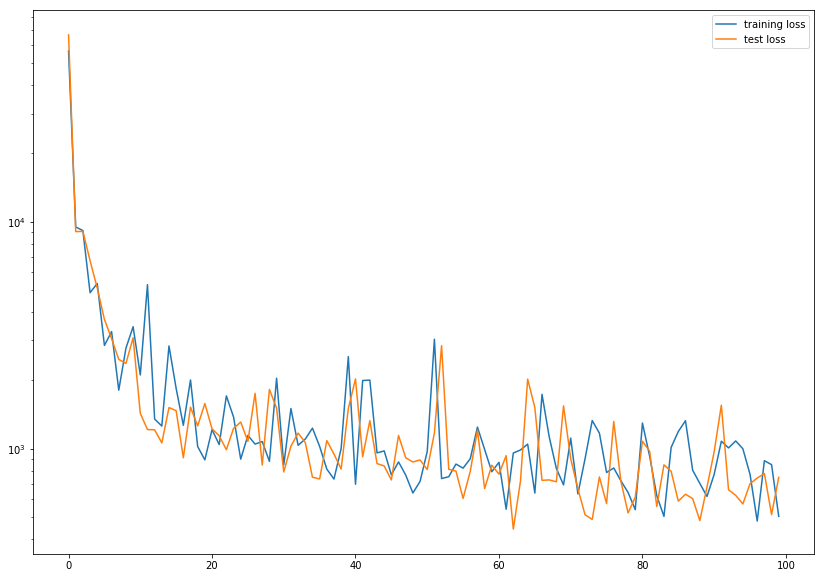

In [125]:
plt.figure(figsize=(14, 10))
plt.semilogy([i for i in range(len(metrics[:,2]))], metrics[:,2], label='training loss')
plt.semilogy([i for i in range(len(metrics[:,3]))], metrics[:,3], label='test loss')
plt.legend(loc='best')
plt.show()

In [126]:
df_vectors = pd.DataFrame(latent_vectors_train, columns=['x', 'y'])

In [127]:
#Join to training data
df_seqs_vectors = df_train.merge(df_vectors, left_index=True, right_index=True)

In [128]:
df_seqs_vectors['label_add'] = df_seqs_vectors['label'].apply(str) + df_seqs_vectors[0].apply(str)

In [129]:
df_seqs_vectors['label_add'].unique()

array(['3.06.0', '4.08.0', '4.07.0', '4.09.0', '2.04.0', '3.05.0',
       '2.07.0', '3.09.0', '5.09.0', '1.09.0', '4.010.0', '2.010.0',
       '5.06.0', '4.05.0', '1.04.0', '3.03.0', '1.010.0', '1.06.0',
       '3.04.0', '4.03.0', '5.08.0', '1.05.0', '2.03.0', '5.05.0',
       '5.04.0', '4.04.0', '2.05.0', '1.03.0', '2.08.0', '3.010.0',
       '5.010.0', '5.03.0', '2.09.0', '2.06.0', '1.08.0', '1.07.0',
       '3.08.0', '3.07.0', '4.06.0', '5.07.0'], dtype=object)

In [130]:
df_seqs_vectors[df_seqs_vectors[0]==3].head()

,0,1,2,3,4,label,x,y,label_add
18,3.0,6.0,9.0,12.0,0.0,3.0,0.723117,0.448238,3.03.0
27,3.0,7.0,11.0,0.0,0.0,4.0,0.358903,0.941783,4.03.0
35,3.0,5.0,7.0,0.0,0.0,2.0,0.486740,1.005442,2.03.0
41,3.0,4.0,5.0,6.0,7.0,1.0,1.049593,0.699132,1.03.0
43,3.0,7.0,11.0,0.0,0.0,4.0,0.358903,0.941783,4.03.0


In [131]:
label_col = 'label'

In [132]:
unique_seqs = df_seqs_vectors[label_col].unique()

In [133]:
palette = itertools.cycle(sns.color_palette(n_colors=len(unique_seqs)))

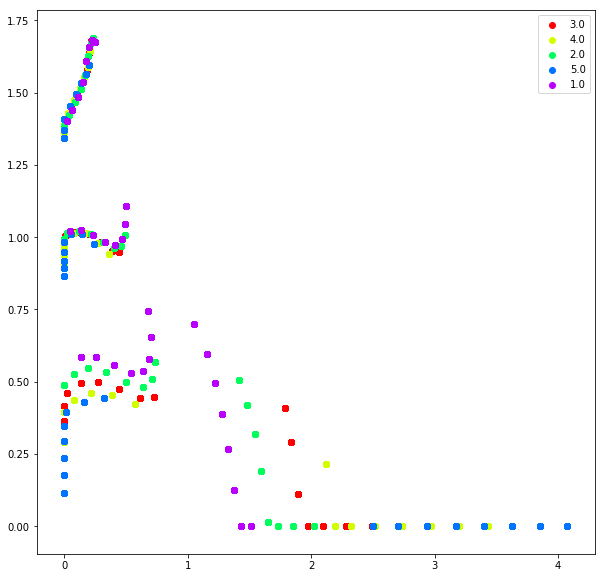

In [134]:
#Analysis

plt.figure(1, figsize=(10, 10))
cmap = plt.cm.get_cmap('hsv', len(unique_seqs)+1)
for idx_seq, seq in enumerate(unique_seqs):
    df_current = df_seqs_vectors[df_seqs_vectors[label_col]==seq]
    plt.scatter(df_current['x'].values, df_current['y'].values, color=cmap(idx_seq), label=seq)

plt.legend(loc='best')
plt.show()